## Load Data

In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
import numpy as np

torch.manual_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
batch_size = 512
num_epochs = 300
lr = 0.01

In [3]:
train_dataset = FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataset = FashionMNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size)

100%|██████████| 26421880/26421880 [00:01<00:00, 14019746.18it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 267122.28it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4950154.57it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 2442565.27it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## Model 1

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.05)
                nn.init.constant_(m.bias, 0.0)


    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)

        return out

In [5]:
model1 = MLP(input_dims=784, hidden_dims=128, output_dims=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=lr)

In [6]:
model1

MLP(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
train_losses = []
train_acc = []
val_losses = []
val_acc = []

for epoch in range(num_epochs):
    model1.train()
    t_loss = 0
    t_acc = 0
    cnt = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model1(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_acc += (torch.argmax(outputs, 1) == y).sum().item()
        cnt += len(y)
    t_loss /= len(train_loader)
    train_losses.append(t_loss)
    t_acc /= cnt
    train_acc.append(t_acc)

    model1.eval()
    v_loss = 0
    v_acc = 0
    cnt = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model1(X)
            loss = criterion(outputs, y)
            v_loss += loss.item()
            v_acc += (torch.argmax(outputs, 1) == y).sum().item()
            cnt += len(y)
    v_loss /= len(test_loader)
    val_losses.append(v_loss)
    v_acc /= cnt
    val_acc.append(v_acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Train_Loss: {t_loss:.4f}, Train_Acc: {t_acc:.4f}, Validation Loss: {v_loss:.4f}, Val_Acc: {v_acc:.4f}")

Epoch 1/300, Train_Loss: 2.3054, Train_Acc: 0.1009, Validation Loss: 2.3027, Val_Acc: 0.1000
Epoch 2/300, Train_Loss: 2.3028, Train_Acc: 0.0994, Validation Loss: 2.3025, Val_Acc: 0.0979
Epoch 3/300, Train_Loss: 2.3026, Train_Acc: 0.1017, Validation Loss: 2.3026, Val_Acc: 0.0999
Epoch 4/300, Train_Loss: 2.3026, Train_Acc: 0.1021, Validation Loss: 2.3024, Val_Acc: 0.1000
Epoch 5/300, Train_Loss: 2.3025, Train_Acc: 0.1037, Validation Loss: 2.3024, Val_Acc: 0.1000
Epoch 6/300, Train_Loss: 2.3024, Train_Acc: 0.1056, Validation Loss: 2.3024, Val_Acc: 0.1000
Epoch 7/300, Train_Loss: 2.3024, Train_Acc: 0.0985, Validation Loss: 2.3021, Val_Acc: 0.1604
Epoch 8/300, Train_Loss: 2.3023, Train_Acc: 0.1094, Validation Loss: 2.3021, Val_Acc: 0.1000
Epoch 9/300, Train_Loss: 2.3022, Train_Acc: 0.1071, Validation Loss: 2.3021, Val_Acc: 0.1000
Epoch 10/300, Train_Loss: 2.3020, Train_Acc: 0.1077, Validation Loss: 2.3022, Val_Acc: 0.1000
Epoch 11/300, Train_Loss: 2.3021, Train_Acc: 0.1054, Validation Loss:

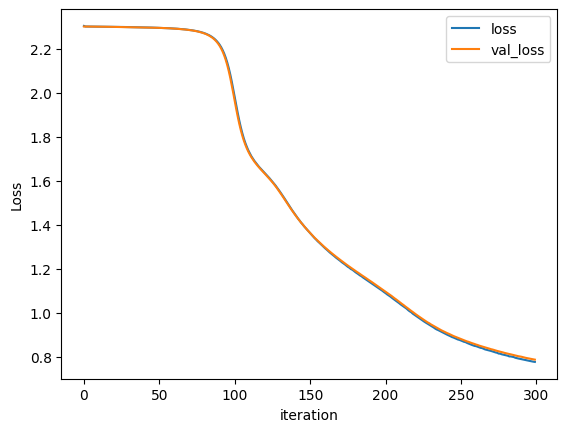

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

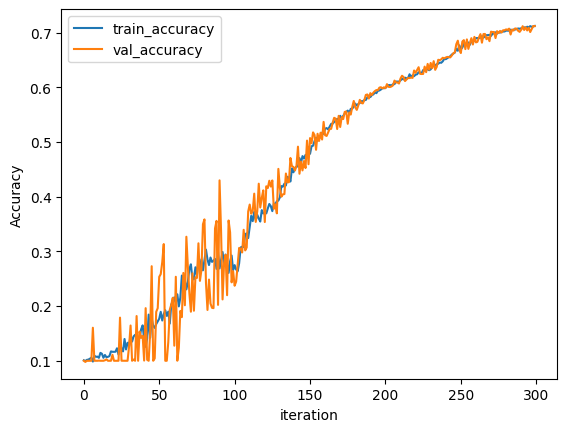

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_acc, label='train_accuracy')
plt.plot(val_acc, label='val_accuracy')
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()

## Model 2

In [7]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.05)
                nn.init.constant_(m.bias, 0.0)


    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)

        return out

In [8]:
model2 = MLP(input_dims=784, hidden_dims=128, output_dims=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=lr)

In [9]:
model2

MLP(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=128, bias=True)
  (layer5): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
train_losses = []
train_acc = []
val_losses = []
val_acc = []

for epoch in range(num_epochs):
    model2.train()
    t_loss = 0
    t_acc = 0
    cnt = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model2(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_acc += (torch.argmax(outputs, 1) == y).sum().item()
        cnt += len(y)
    t_loss /= len(train_loader)
    train_losses.append(t_loss)
    t_acc /= cnt
    train_acc.append(t_acc)

    model2.eval()
    v_loss = 0
    v_acc = 0
    cnt = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model2(X)
            loss = criterion(outputs, y)
            v_loss += loss.item()
            v_acc += (torch.argmax(outputs, 1) == y).sum().item()
            cnt += len(y)
    v_loss /= len(test_loader)
    val_losses.append(v_loss)
    v_acc /= cnt
    val_acc.append(v_acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Train_Loss: {t_loss:.4f}, Train_Acc: {t_acc:.4f}, Validation Loss: {v_loss:.4f}, Val_Acc: {v_acc:.4f}")

Epoch 1/300, Train_Loss: 2.3072, Train_Acc: 0.0988, Validation Loss: 2.3026, Val_Acc: 0.1000
Epoch 2/300, Train_Loss: 2.3028, Train_Acc: 0.1009, Validation Loss: 2.3027, Val_Acc: 0.1000
Epoch 3/300, Train_Loss: 2.3028, Train_Acc: 0.0972, Validation Loss: 2.3027, Val_Acc: 0.1000
Epoch 4/300, Train_Loss: 2.3028, Train_Acc: 0.0987, Validation Loss: 2.3027, Val_Acc: 0.1000
Epoch 5/300, Train_Loss: 2.3028, Train_Acc: 0.0995, Validation Loss: 2.3028, Val_Acc: 0.1000
Epoch 6/300, Train_Loss: 2.3028, Train_Acc: 0.0999, Validation Loss: 2.3026, Val_Acc: 0.1000
Epoch 7/300, Train_Loss: 2.3028, Train_Acc: 0.0990, Validation Loss: 2.3027, Val_Acc: 0.1000
Epoch 8/300, Train_Loss: 2.3028, Train_Acc: 0.0983, Validation Loss: 2.3027, Val_Acc: 0.1000
Epoch 9/300, Train_Loss: 2.3028, Train_Acc: 0.0992, Validation Loss: 2.3028, Val_Acc: 0.1000
Epoch 10/300, Train_Loss: 2.3028, Train_Acc: 0.1005, Validation Loss: 2.3026, Val_Acc: 0.1000
Epoch 11/300, Train_Loss: 2.3028, Train_Acc: 0.0965, Validation Loss:

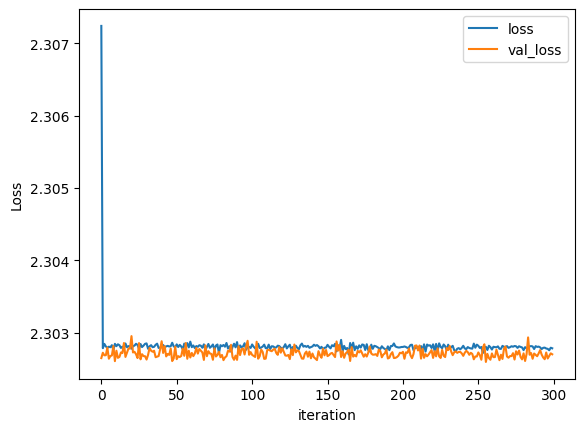

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

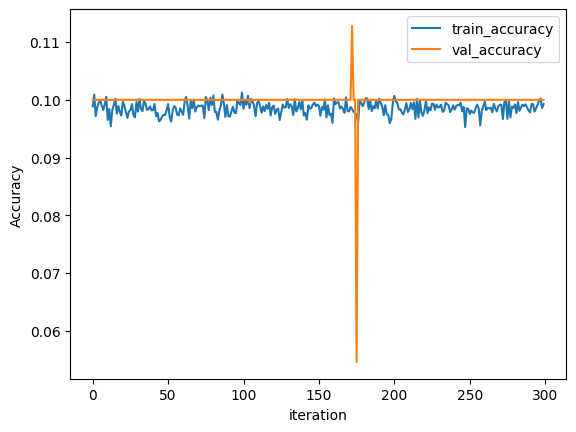

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_acc, label='train_accuracy')
plt.plot(val_acc, label='val_accuracy')
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()

## Model 3

In [10]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.05)
                nn.init.constant_(m.bias, 0.0)


    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)

        return out

In [11]:
model3 = MLP(input_dims=784, hidden_dims=128, output_dims=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=lr)

In [12]:
model3

MLP(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=128, bias=True)
  (layer5): Linear(in_features=128, out_features=128, bias=True)
  (layer6): Linear(in_features=128, out_features=128, bias=True)
  (layer7): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
train_losses = []
train_acc = []
val_losses = []
val_acc = []

for epoch in range(num_epochs):
    model3.train()
    t_loss = 0
    t_acc = 0
    cnt = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model3(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_acc += (torch.argmax(outputs, 1) == y).sum().item()
        cnt += len(y)
    t_loss /= len(train_loader)
    train_losses.append(t_loss)
    t_acc /= cnt
    train_acc.append(t_acc)

    model3.eval()
    v_loss = 0
    v_acc = 0
    cnt = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model3(X)
            loss = criterion(outputs, y)
            v_loss += loss.item()
            v_acc += (torch.argmax(outputs, 1) == y).sum().item()
            cnt += len(y)
    v_loss /= len(test_loader)
    val_losses.append(v_loss)
    v_acc /= cnt
    val_acc.append(v_acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Train_Loss: {t_loss:.4f}, Train_Acc: {t_acc:.4f}, Validation Loss: {v_loss:.4f}, Val_Acc: {v_acc:.4f}")

Epoch 1/300, Train_Loss: 2.3076, Train_Acc: 0.1001, Validation Loss: 2.3027, Val_Acc: 0.1000
Epoch 2/300, Train_Loss: 2.3028, Train_Acc: 0.0993, Validation Loss: 2.3028, Val_Acc: 0.1000
Epoch 3/300, Train_Loss: 2.3028, Train_Acc: 0.0999, Validation Loss: 2.3028, Val_Acc: 0.1000
Epoch 4/300, Train_Loss: 2.3028, Train_Acc: 0.0969, Validation Loss: 2.3027, Val_Acc: 0.1000
Epoch 5/300, Train_Loss: 2.3028, Train_Acc: 0.0982, Validation Loss: 2.3027, Val_Acc: 0.1000
Epoch 6/300, Train_Loss: 2.3028, Train_Acc: 0.0987, Validation Loss: 2.3027, Val_Acc: 0.1000
Epoch 7/300, Train_Loss: 2.3028, Train_Acc: 0.0977, Validation Loss: 2.3027, Val_Acc: 0.1000
Epoch 8/300, Train_Loss: 2.3028, Train_Acc: 0.0996, Validation Loss: 2.3027, Val_Acc: 0.1000
Epoch 9/300, Train_Loss: 2.3028, Train_Acc: 0.1003, Validation Loss: 2.3027, Val_Acc: 0.1000
Epoch 10/300, Train_Loss: 2.3028, Train_Acc: 0.0978, Validation Loss: 2.3027, Val_Acc: 0.1000
Epoch 11/300, Train_Loss: 2.3028, Train_Acc: 0.0990, Validation Loss:

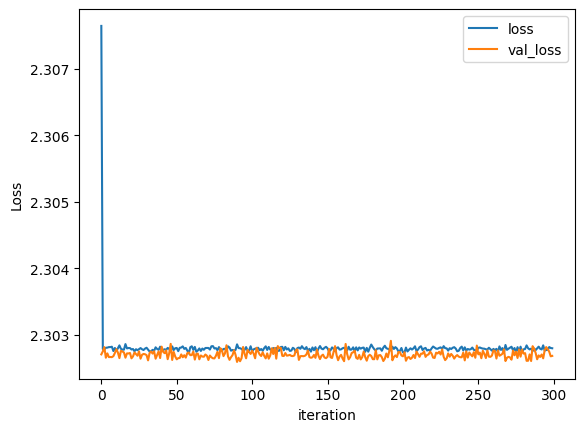

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

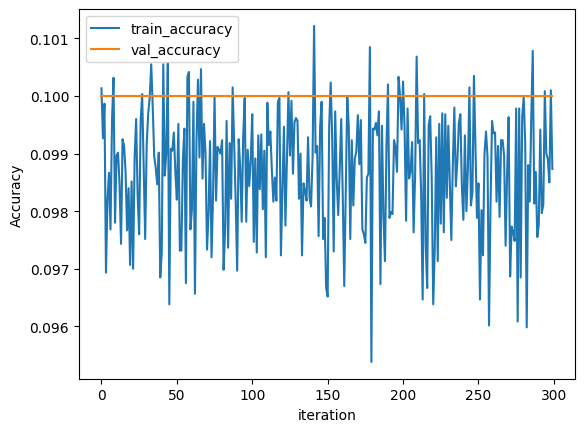

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_acc, label='train_accuracy')
plt.plot(val_acc, label='val_accuracy')
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()